# Import requirements

In [1]:
import sys
sys.path.append("../src")
import os
from scipy.io import loadmat
import torch
import numpy as np
import matplotlib.pyplot as plt
from plotUtils import plotTrueAndEstimatedLatents
from kernels import PeriodicKernel, ExponentialQuadraticKernel
import svGPFAModelFactory
from svEM import SVEM

# Load data and initial values

In [2]:
yNonStackedFilename = os.path.expanduser("data/YNonStacked.mat")
dataFilename = os.path.expanduser("data/demo_PointProcess.mat")

mat = loadmat(yNonStackedFilename)
YNonStacked = mat['YNonStacked']

mat = loadmat(dataFilename)
nLatents = len(mat['Z0'])
nTrials = mat['Z0'][0,0].shape[2]
qMu0 = [torch.from_numpy(mat['q_mu0'][(0,i)]).type(torch.DoubleTensor).permute(2,0,1) for i in range(nLatents)]
qSVec0 = [torch.from_numpy(mat['q_sqrt0'][(0,i)]).type(torch.DoubleTensor).permute(2,0,1) for i in range(nLatents)]
qSDiag0 = [torch.from_numpy(mat['q_diag0'][(0,i)]).type(torch.DoubleTensor).permute(2,0,1) for i in range(nLatents)]
Z0 = [torch.from_numpy(mat['Z0'][(i,0)]).type(torch.DoubleTensor).permute(2,0,1) for i in range(nLatents)]
C0 = torch.from_numpy(mat["C0"]).type(torch.DoubleTensor)
b0 = torch.from_numpy(mat["b0"]).type(torch.DoubleTensor).squeeze()
legQuadPoints = torch.from_numpy(mat['ttQuad']).type(torch.DoubleTensor).permute(2, 0, 1)
legQuadWeights = torch.from_numpy(mat['wwQuad']).type(torch.DoubleTensor).permute(2, 0, 1)
kernelNames = mat["kernelNames"]
hprs0 = mat["hprs0"]
testTimes = torch.from_numpy(mat['testTimes']).type(torch.DoubleTensor).squeeze()
trueLatents = [[torch.from_numpy(mat['trueLatents'][tr,k]).type(torch.DoubleTensor) 
                for tr in range(nTrials)] for k in range(nLatents)]

# Create kernels

In [3]:
kernels = [[None] for k in range(nLatents)]
for k in range(nLatents):
    if np.char.equal(kernelNames[0,k][0], "PeriodicKernel"):
        kernels[k] = PeriodicKernel(scale=1.0)
    elif np.char.equal(kernelNames[0,k][0], "rbfKernel"):
        kernels[k] = ExponentialQuadraticKernel(scale=1.0)
    else:
        raise ValueError("Invalid kernel name: %s"%(kernelNames[k]))

# Set parameters

In [4]:
kernelsParams0 = [[None] for k in range(nLatents)]
for k in range(nLatents):
    if np.char.equal(kernelNames[0,k][0], "PeriodicKernel"):
        kernelsParams0[k] = torch.tensor([float(hprs0[k,0][0]),
                                          float(hprs0[k,0][1])],
                                         dtype=torch.double)
    elif np.char.equal(kernelNames[0,k][0], "rbfKernel"):
        kernelsParams0[k] = torch.tensor([float(hprs0[k,0][0])],
                                         dtype=torch.double)
    else:
        raise ValueError("Invalid kernel name: %s"%(kernelNames[k]))
qUParams0 = {"qMu0": qMu0, "qSVec0": qSVec0, "qSDiag0": qSDiag0}
qHParams0 = {"C0": C0, "d0": b0}
kmsParams0 = {"kernelsParams0": kernelsParams0,
              "inducingPointsLocs0": Z0}
initialParams = {"svPosteriorOnIndPoints": qUParams0,
                 "kernelsMatricesStore": kmsParams0,
                 "svEmbedding": qHParams0}
quadParams = {"legQuadPoints": legQuadPoints,
              "legQuadWeights": legQuadWeights}
optimParams = {"emMaxNIter":20, 
               "eStepMaxNIter":100, 
               "mStepModelParamsMaxNIter":100, 
               "mStepKernelParamsMaxNIter":100, 
               "mStepKernelParamsLR":1e-5, 
               "mStepIndPointsMaxNIter":100}        

# Create model

In [5]:
    model = svGPFAModelFactory.SVGPFAModelFactory.buildModel(
        conditionalDist=svGPFAModelFactory.PointProcess,
        linkFunction=svGPFAModelFactory.ExponentialLink,
        embeddingType=svGPFAModelFactory.LinearEmbedding)

# Maximize the Lower Bound
<span style="color:red">(Warning: with the parameters above, this step takes around 15 minutes)</span>

In [6]:
svEM = SVEM()
maxRes = svEM.maximize(model=model, measurements=YNonStacked,
                       kernels=kernels, initialParams=initialParams,
                       quadParams=quadParams, optimParams=optimParams)


> /nfs/nhome/live/rapela/dev/research/gatsby-swc/gatsby/svGPFA/code/src/expectedLogLikelihood.py(110)setMeasurements()
-> self._svEmbeddingAssocTimes.setTimes(times=stackedSpikeTimes)
(Pdb) c
Iteration 00, E-Step start
Step: 0, negative lower bound: 6180.619714
Step: 10, negative lower bound: 5897.382703
Step: 20, negative lower bound: 5842.245101
Step: 30, negative lower bound: 5817.133451
Step: 40, negative lower bound: 5796.160623
Step: 50, negative lower bound: 5778.063401
Step: 60, negative lower bound: 5763.020886
Step: 70, negative lower bound: 5749.798419
Step: 80, negative lower bound: 5737.653666
Step: 90, negative lower bound: 5726.218390
Iteration 00, E-Step end: 5716.413622
Iteration 00, M-Step Model Params start
Step: 0, negative sum of expected log likelihood: 5430.989335
Step: 10, negative sum of expected log likelihood: 5410.622403
Step: 20, negative sum of expected log likelihood: 5391.255318
Step: 30, negative sum of expected log likelihood: 5372.908972
Step: 40, neg

Iteration 03, M-Step Model Params end: 4707.571667
Iteration 03, M-Step Kernel Params start
Step: 0, negative lower bound: 4915.539192
Step: 10, negative lower bound: 4915.515179
Step: 20, negative lower bound: 4915.477323
Step: 30, negative lower bound: 4915.448955
Step: 40, negative lower bound: 4915.424092
Step: 50, negative lower bound: 4915.400739
Step: 60, negative lower bound: 4915.378481
Step: 70, negative lower bound: 4915.356713
Step: 80, negative lower bound: 4915.334898
Step: 90, negative lower bound: 4915.313109
Iteration 03, M-Step Kernel Params end: 4915.293530
Iteration 03, M-Step Ind Points start
Step: 0, negative lower bound: 4915.291353
Step: 10, negative lower bound: 4925.555267
Step: 20, negative lower bound: 4917.987693
Step: 30, negative lower bound: 4915.100530
Step: 40, negative lower bound: 4913.662884
Step: 50, negative lower bound: 4912.530215
Step: 60, negative lower bound: 4911.671892
Step: 70, negative lower bound: 4911.002992
Step: 80, negative lower bou

Step: 50, negative lower bound: 4795.780223
Step: 60, negative lower bound: 4794.786511
Step: 70, negative lower bound: 4793.842237
Step: 80, negative lower bound: 4792.937653
Step: 90, negative lower bound: 4792.067642
Iteration 07, E-Step end: 4791.311775
Iteration 07, M-Step Model Params start
Step: 0, negative sum of expected log likelihood: 4604.229329
Step: 10, negative sum of expected log likelihood: 4603.251017
Step: 20, negative sum of expected log likelihood: 4602.837261
Step: 30, negative sum of expected log likelihood: 4602.550712
Step: 40, negative sum of expected log likelihood: 4602.303225
Step: 50, negative sum of expected log likelihood: 4602.093933
Step: 60, negative sum of expected log likelihood: 4601.910822
Step: 70, negative sum of expected log likelihood: 4601.749692
Step: 80, negative sum of expected log likelihood: 4601.607511
Step: 90, negative sum of expected log likelihood: 4601.481432
Iteration 07, M-Step Model Params end: 4601.380199
Iteration 07, M-Step K

Step: 80, negative lower bound: 4752.224558
Step: 90, negative lower bound: 4752.213316
Iteration 10, M-Step Kernel Params end: 4752.203147
Iteration 10, M-Step Ind Points start
Step: 0, negative lower bound: 4752.202003
Step: 10, negative lower bound: 4798.372799
Step: 20, negative lower bound: 4762.548436
Step: 30, negative lower bound: 4760.389675
Step: 40, negative lower bound: 4756.544858
Step: 50, negative lower bound: 4754.756490
Step: 60, negative lower bound: 4753.603622
Step: 70, negative lower bound: 4752.700126
Step: 80, negative lower bound: 4752.012660
Step: 90, negative lower bound: 4751.456473
Iteration 10, M-Step Ind Points end: 4751.058608
Iteration 11, E-Step start
Step: 0, negative lower bound: 4751.020120
Step: 10, negative lower bound: 4751.095357
Step: 20, negative lower bound: 4749.463571
Step: 30, negative lower bound: 4748.619655
Step: 40, negative lower bound: 4748.037808
Step: 50, negative lower bound: 4747.517400
Step: 60, negative lower bound: 4747.039092


Step: 30, negative sum of expected log likelihood: 4553.454902
Step: 40, negative sum of expected log likelihood: 4553.452868
Step: 50, negative sum of expected log likelihood: 4553.452206
Step: 60, negative sum of expected log likelihood: 4553.451804
Step: 70, negative sum of expected log likelihood: 4553.451664
Step: 80, negative sum of expected log likelihood: 4553.451620
Step: 90, negative sum of expected log likelihood: 4553.451606
Iteration 14, M-Step Model Params end: 4553.451602
Iteration 14, M-Step Kernel Params start
Step: 0, negative lower bound: 4729.386757
Step: 10, negative lower bound: 4729.704292
Step: 20, negative lower bound: 4729.401832
Step: 30, negative lower bound: 4729.330236
Step: 40, negative lower bound: 4729.327204
Step: 50, negative lower bound: 4729.316420
Step: 60, negative lower bound: 4729.305809
Step: 70, negative lower bound: 4729.296522
Step: 80, negative lower bound: 4729.288084
Step: 90, negative lower bound: 4729.279915
Iteration 14, M-Step Kernel 

Step: 70, negative lower bound: 4720.611758
Step: 80, negative lower bound: 4720.176015
Step: 90, negative lower bound: 4719.885404
Iteration 17, M-Step Ind Points end: 4719.717807
Iteration 18, E-Step start
Step: 0, negative lower bound: 4719.702669
Step: 10, negative lower bound: 4720.380984
Step: 20, negative lower bound: 4719.176193
Step: 30, negative lower bound: 4718.746064
Step: 40, negative lower bound: 4718.558222
Step: 50, negative lower bound: 4718.422822
Step: 60, negative lower bound: 4718.314057
Step: 70, negative lower bound: 4718.217620
Step: 80, negative lower bound: 4718.129829
Step: 90, negative lower bound: 4718.047838
Iteration 18, E-Step end: 4717.977873
Iteration 18, M-Step Model Params start
Step: 0, negative sum of expected log likelihood: 4546.632023
Step: 10, negative sum of expected log likelihood: 4546.491311
Step: 20, negative sum of expected log likelihood: 4546.467973
Step: 30, negative sum of expected log likelihood: 4546.462060
Step: 40, negative sum o

<IPython.core.display.Javascript object>


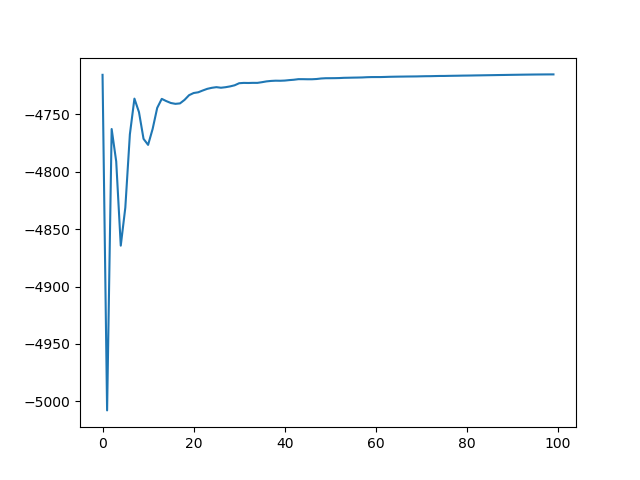

In [15]:
%matplotlib notebook
plt.plot(maxRes["lowerBoundHist"])
plt.show()

# Predict latents at new times

In [7]:
muK, varK = model.predictLatents(newTimes=testTimes)

# Plot latents estimates for one trial

<IPython.core.display.Javascript object>


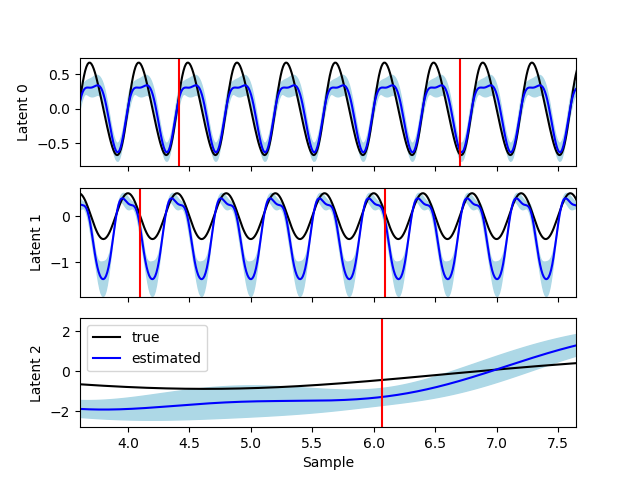

No handles with labels found to put in legend.
No handles with labels found to put in legend.


In [8]:
%matplotlib notebook
trialToPlot=0
indPointsLocs = model.getIndPointsLocs()
nLatents = muK.shape[2]
timesToPlot = testTimes.numpy()
f, axes = plt.subplots(nLatents, 1, sharex=True)
for k in range(nLatents):
    trueLatentToPlot = trueLatents[k][trialToPlot].numpy().squeeze()
    muKToPlot = muK[trialToPlot,:,k].detach().numpy()
    errorToPlot = varK[trialToPlot,:,k].sqrt().detach().numpy()
    axes[k].plot(timesToPlot, trueLatentToPlot, label="true", color="black")
    axes[k].plot(timesToPlot, muKToPlot, label="estimated", color="blue")
    axes[k].fill_between(timesToPlot, muKToPlot-errorToPlot,
                          muKToPlot+errorToPlot, color="lightblue")
    for i in range(indPointsLocs[k].shape[1]):
        axes[k].axvline(x=indPointsLocs[k][trialToPlot,i, 0], color="red")
        axes[k].set_ylabel("Latent %d"%(k))
    axes[-1].set_xlabel("Sample")
    axes[-1].legend()
    plt.xlim(left=np.min(timesToPlot)-1, right=np.max(timesToPlot)+1)
    plt.show()